In [1]:
"""
Pipeline overview:
- Preprocessing: log1p + per-series z-scoring
- Feature extraction: catch22 + interpretable features + PAA
- Micro-clustering: MiniBatchKMeans (euclidean) on features
- Representative selection: medoid per microcluster (DTW distance)
- PAA on medoids
- Final clustering: Agglomerative (average linkage) using DTW distance (metric='precomputed')
- Propagate labels, evaluate against non-time columns, and visual analysis

Notes:
- We purposely use KMeans (euclidean) for micro-clustering and
  Agglomerative+DTW for final clustering (DTW only on reduced set of medoids).
- sklearn AgglomerativeClustering uses `metric='precomputed'` for distance matrices.
- We include progress bars for DTW-heavy operations, and small utilities to save results.
"""

# -------------------------
# 0. Imports and config
# -------------------------
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from tslearn.metrics import cdist_dtw
from pycatch22 import catch22_all
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import Counter
import scipy.stats as stats

sns.set(style='whitegrid')
np.random.seed(0)

In [2]:
DATA_PATH = "/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv"
df = pd.read_csv(DATA_PATH)

In [3]:
df.head()

,id,0,1,2,3,4,5,6,7,8,...,93,94,95,96,97,98,99,rating,genre,rating_category
0,tt0062622,57057.0,65469.0,71642.0,73025.0,74060.0,49472.0,30258.0,28036.0,25824.0,...,10709.0,11042.0,11388.0,11847.0,12404.0,13679.0,15056.0,8.3,"['Adventure', 'Sci-Fi']",High
1,tt0064816,1923.0,2422.0,2853.0,2947.0,3054.0,2844.0,2617.0,1998.0,1277.0,...,637.0,734.0,857.0,785.0,724.0,713.0,699.0,7.1,"['Crime', 'Drama', 'Romance']",High
2,tt0088178,332925.0,302503.0,267264.0,261879.0,256608.0,196530.0,112728.0,117384.0,123024.0,...,6784.0,7253.0,7776.0,9632.0,11212.0,9010.0,6431.0,8.7,"['Documentary', 'Music']",High
3,tt0145487,682857.0,407032.0,78058.0,81732.0,86772.0,83724.0,79940.0,39656.0,6974.0,...,21094.0,10995.0,1586.0,1421.0,1177.0,970.0,802.0,7.4,"['Action', 'Adventure', 'Sci-Fi']",High
4,tt0359950,7813372.0,6274563.0,4781588.0,4655046.0,4535301.0,4650574.0,4758452.0,4069428.0,3471755.0,...,88635.0,68347.0,45367.0,28915.0,15494.0,16155.0,16853.0,7.3,"['Adventure', 'Comedy', 'Drama']",High


In [15]:
# -------------------------
# 1. Utilities
# -------------------------

def safe_read_csv(path):
    assert os.path.exists(path), f"File not found: {path}"
    df = pd.read_csv(path)
    return df

# Function: z-score per series (rows)
def preprocess_series(Y):
    # Y: (n_series, n_time)
    Y = np.array(Y, dtype=float)
    Y_log = np.log1p(Y)
    scaler = StandardScaler()
    # StandardScaler works on features axis; we want per-row zscore
    Y_z = scaler.fit_transform(Y_log.T).T
    return Y_z

# -------------------------
# 2. Feature extraction
# -------------------------

def extract_features_catch22(Y_z):
    feats = []
    names = None
    for ts in tqdm(Y_z, desc='catch22'):  # progress bar
        res = catch22_all(ts)
        if names is None:
            names = res['names']
        feats.append(res['values'])
    return pd.DataFrame(feats, columns=names)


# def extract_features_interpretable(Y_z, M=12):
#     feats = []
#     for ts in Y_z:
#         peak_day = int(np.argmax(ts))
#         decay = float(ts[7:14].sum() / (ts[0:7].sum() + 1e-8))
#         tail_share = float(ts[29:100].sum() / (ts.sum() + 1e-8))
#         seglen = len(ts) // M
#         paa = [float(ts[i*seglen:(i+1)*seglen].mean()) for i in range(M)]
#         feats.append([peak_day, decay, tail_share] + paa)
#     cols = ["peak_day", "decay", "tail_share"] + [f"PAA{i}" for i in range(M)]
#     return pd.DataFrame(feats, columns=cols)

# -------------------------
# 3. Microclustering
# -------------------------

def microcluster(features, k=200, batch_size=256, random_state=0):
    model = MiniBatchKMeans(n_clusters=k, random_state=random_state, batch_size=batch_size)
    labels = model.fit_predict(features)
    return labels, model

# -------------------------
# 4. Cluster representatives (medoid) using DTW
# -------------------------

def compute_cluster_representatives(Y, labels, method="medoid", use_tqdm=True):
    reps = []
    cluster_map = {}
    unique_clusters = np.unique(labels)
    iterator = unique_clusters
    if use_tqdm:
        iterator = tqdm(unique_clusters, desc='clusters->medoid')
    for idx_c, c in enumerate(iterator):
        idx = np.where(labels == c)[0]
        cluster_ts = Y[idx]
        if method == "mean":
            reps.append(cluster_ts.mean(axis=0))
        elif method == "medoid":
            # compute pairwise DTW distances and pick medoid
            if cluster_ts.shape[0] == 1:
                reps.append(cluster_ts[0])
            else:
                dist_mat = cdist_dtw(cluster_ts, cluster_ts)
                medoid_idx = int(np.argmin(dist_mat.sum(axis=1)))
                reps.append(cluster_ts[medoid_idx])
        cluster_map[c] = idx_c
    return np.array(reps), cluster_map

# -------------------------
# 5. PAA transform
# -------------------------

def paa_transform(Y, M=20):
    paa_list = []
    for ts in Y:
        seglen = len(ts) // M
        paa = [float(ts[i*seglen:(i+1)*seglen].mean()) for i in range(M)]
        paa_list.append(paa)
    return np.array(paa_list)

# -------------------------
# 6. Final clustering (Agglomerative with DTW)
# -------------------------

def final_clustering_agglodtw(PAA, k=5, progress=True):
    # compute DTW distance matrix once
    if progress:
        print("Computing DTW distance matrix (this may take a while for many representatives)...")
    D = cdist_dtw(PAA, PAA)
    # sklearn modern API: metric='precomputed'
    model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    labels = model.fit_predict(D)
    return labels, model, D

# helper: kmeans on PAA (if desired)
def final_clustering_kmeans(PAA, k=5, random_state=0):
    model = KMeans(n_clusters=k, random_state=random_state)
    labels = model.fit_predict(PAA)
    return labels, model

# -------------------------
# 7. Propagate and evaluate
# -------------------------

def propagate_final_labels(micro_labels, final_labels, cluster_map):
    # cluster_map: micro_cluster_label -> index in reps/final_labels
    return np.array([final_labels[cluster_map[micro_labels[i]]] for i in range(len(micro_labels))])


def evaluate(labels, meta, label_col):
    ari = adjusted_rand_score(meta[label_col], labels)
    nmi = normalized_mutual_info_score(meta[label_col], labels)
    return ari, nmi

# -------------------------
# 8. Cluster analysis vs metadata
# -------------------------

def cluster_vs_metadata(df_meta, labels, cat_cols=None, cont_cols=None, top_n=10):
    # df_meta: DataFrame aligned with labels
    out = {}
    df = df_meta.copy()
    df['cluster'] = labels
    if cat_cols is None:
        cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    if cont_cols is None:
        cont_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Categorical: contingency tables and chi2
    cat_results = {}
    for c in cat_cols:
        table = pd.crosstab(df['cluster'], df[c])
        try:
            chi2, p, dof, _ = stats.chi2_contingency(table)
        except Exception:
            chi2, p, dof = np.nan, np.nan, np.nan
        cat_results[c] = {'contingency': table, 'chi2': chi2, 'pvalue': p}
    # Continuous: ANOVA across clusters
    cont_results = {}
    for c in cont_cols:
        groups = [df[df['cluster']==cl][c].dropna().values for cl in sorted(df['cluster'].unique())]
        try:
            f, p = stats.f_oneway(*groups)
        except Exception:
            f, p = np.nan, np.nan
        cont_results[c] = {'F': f, 'pvalue': p, 'means': df.groupby('cluster')[c].mean()}
    out['categorical'] = cat_results
    out['continuous'] = cont_results
    return out

# -------------------------
# 9. Plotting helpers
# -------------------------

def plot_cluster_centroids(reps, title="Cluster Representatives", n_show=20):
    plt.figure(figsize=(12, 6))
    for i, ts in enumerate(reps[:n_show]):
        plt.plot(ts, label=f"Cluster {i}")
    plt.title(title)
    plt.xlabel("Day")
    plt.ylabel("Normalized")
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_paa_clusters(PAA, final_labels, title="Final Clusters (PAA)"):
    df = pd.DataFrame(PAA)
    df['cluster'] = final_labels
    plt.figure(figsize=(10,5))
    for c in sorted(np.unique(final_labels)):
        mean_curve = df[df['cluster']==c].iloc[:, :-1].mean(axis=0)
        plt.plot(range(mean_curve.shape[0]), mean_curve, label=f"Cluster {c}")
    plt.title(title)
    plt.xlabel("PAA Segment")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


def plot_cluster_distribution(labels, meta, label_col="rating_category", title="Cluster Distribution"):
    df = pd.DataFrame({"cluster": labels, "meta": meta[label_col]})
    cross = pd.crosstab(df['cluster'], df['meta'], normalize='index')
    cross.plot(kind='bar', stacked=True, figsize=(10,5), colormap='tab20')
    plt.title(f"{title} by {label_col}")
    plt.ylabel("Fraction")
    plt.xlabel("Cluster")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2,1))
    plt.tight_layout()
    plt.show()


Preprocessing time series...
Extracting catch22 features...


catch22:   0%|          | 0/1134 [00:00<?, ?it/s]

Running microclustering (k=200)...
Computing medoids for microclusters (DTW)


clusters->medoid:   0%|          | 0/200 [00:00<?, ?it/s]

Computing PAA on medoids...
Final clustering with Agglomerative+DTW (k=5)
Computing DTW distance matrix (this may take a while for many representatives)...
Plotting dendrogram to inspect possible cluster structure...


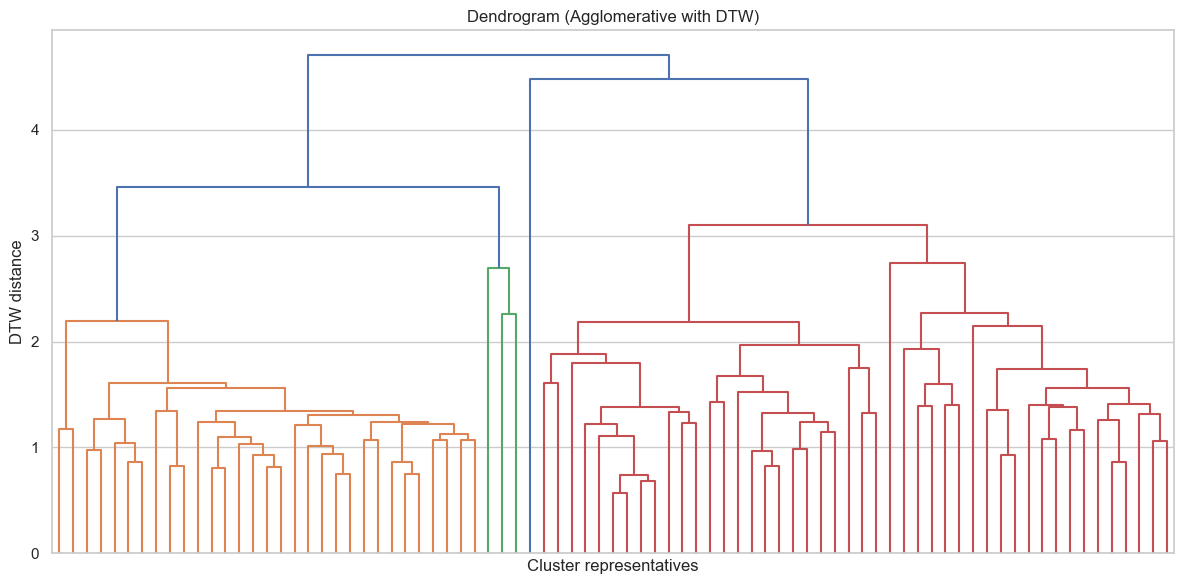

In [43]:

# -------------------------
# 10. Main execution 
# -------------------------
if __name__ == '__main__':
    DATA_PATH = "/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv"
    df = safe_read_csv(DATA_PATH)

    # Expecting first 100 columns be '0'..'99' (strings) or numbers
    time_cols = [str(i) for i in range(100)]
    missing = [c for c in time_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing expected time columns: {missing}")

    Y = df[time_cols].values
    meta = df.drop(columns=time_cols)

    # 1. Preprocess
    print("Preprocessing time series...")
    Y_z = preprocess_series(Y)

    # 2. Feature extraction
    print("Extracting catch22 features...")
    feats_c22 = extract_features_catch22(Y_z)
    # print("Extracting interpretable features...")
    # feats_interp = extract_features_interpretable(Y_z, M=12)
    # feats = pd.concat([feats_c22, feats_interp], axis=1)
    feats = feats_c22  # using only catch22 for simplicity

    # 3. Microclustering
    MICRO_K = 200
    print(f"Running microclustering (k={MICRO_K})...")
    micro_labels, micro_model = microcluster(feats, k=MICRO_K)

    # 4. Representatives (medoid) using DTW
    print("Computing medoids for microclusters (DTW)")
    reps, cluster_map = compute_cluster_representatives(Y_z, micro_labels, method='medoid', use_tqdm=True)

    # 5. PAA on medoids
    print("Computing PAA on medoids...")
    M = 20
    PAA_reps = paa_transform(reps, M=M)

    # 6. Final clustering with Agglomerative + DTW
    FINAL_K = 5
    print(f"Final clustering with Agglomerative+DTW (k={FINAL_K})")
    final_labels_reps, final_model, Dmat = final_clustering_agglodtw(PAA_reps, k=FINAL_K, progress=True)


    # --- NEW SECTION: Dendrogram analysis ---
    from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
    import matplotlib.pyplot as plt
    import numpy as np

    print("Plotting dendrogram to inspect possible cluster structure...")
    # Convert the upper triangle of Dmat into condensed distance format for linkage
    condensed_D = Dmat[np.triu_indices_from(Dmat, k=1)]
    Z = linkage(condensed_D, method='average')

    plt.figure(figsize=(12, 6))
    dendrogram(Z, truncate_mode='level', p=10, no_labels=True)
    plt.title("Dendrogram (Agglomerative with DTW)")
    plt.xlabel("Cluster representatives")
    plt.ylabel("DTW distance")
    plt.tight_layout()
    plt.show()




Eval vs genre: ARI=0.0023, NMI=0.0761
Eval vs rating_category: ARI=0.0057, NMI=0.0611
Running cluster vs metadata statistical tests...
Categorical column: genre - chi2=1120.325, p=8.19e-19
Categorical column: rating_category - chi2=121.404, p=2.95e-18
Continuous column: rating - F=26.589800433442484, p=4.2065789176275665e-21
Continuous column: cluster - F=inf, p=0.0
Plotting PAA cluster centers...


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


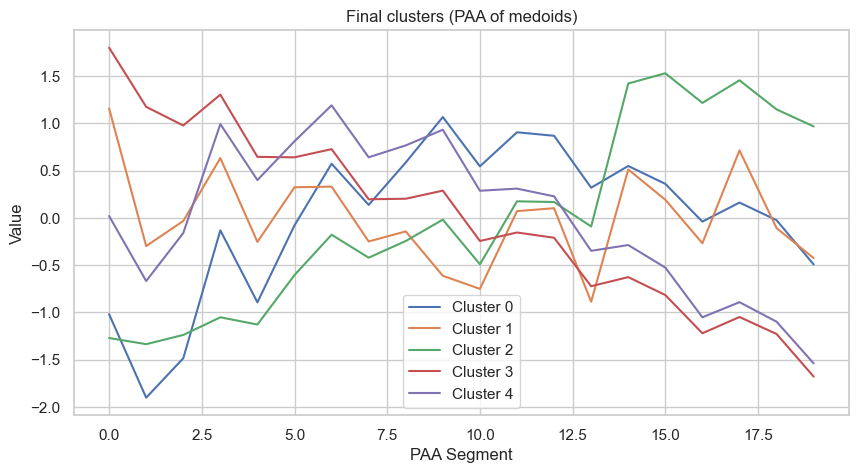

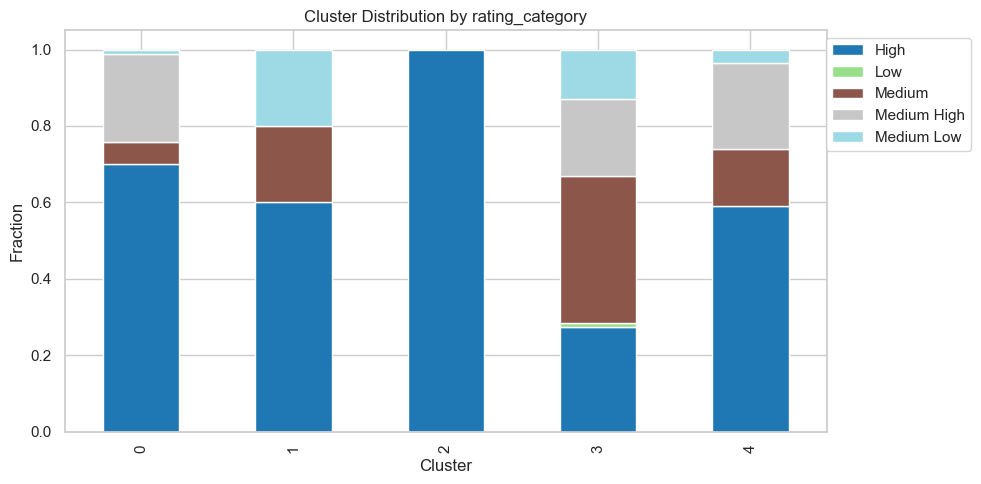

Saved clustering results to: /Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts_clusters.csv


In [44]:
# 7. Propagate labels back to original series
final_labels_all = propagate_final_labels(micro_labels, final_labels_reps, cluster_map)

# 8. Evaluate vs metadata (if present)
for col in ['genre', 'rating_category']:
    if col in meta.columns:
        ari, nmi = evaluate(final_labels_all, meta.reset_index(drop=True), col)
        print(f"Eval vs {col}: ARI={ari:.4f}, NMI={nmi:.4f}")

# 9. Cluster vs metadata analysis
print("Running cluster vs metadata statistical tests...")
analysis = cluster_vs_metadata(meta.reset_index(drop=True), final_labels_all,
                                   cat_cols=['genre','rating_category'] if set(['genre','rating_category']).issubset(meta.columns) else None,
                                   cont_cols=None)

# Print top results (concise)
for c, v in analysis['categorical'].items():
    print(f"Categorical column: {c} - chi2={v['chi2']:.3f}, p={v['pvalue']:.3g}")
for c, v in analysis['continuous'].items():
    print(f"Continuous column: {c} - F={v['F']}, p={v['pvalue']}")

# 10. Visualizations
print("Plotting PAA cluster centers...")
plot_paa_clusters(PAA_reps, final_labels_reps, title='Final clusters (PAA of medoids)')
if reps.shape[0] <= 50:
    plot_cluster_centroids(reps, title='Medoids (first 50)')

if 'rating_category' in meta.columns:
    plot_cluster_distribution(final_labels_all, meta.reset_index(drop=True), label_col='rating_category')

# Save results
out_df = meta.copy()
out_df['cluster'] = final_labels_all
out_path = os.path.splitext(DATA_PATH)[0] + '_clusters.csv'
out_df.to_csv(out_path, index=False)
print(f"Saved clustering results to: {out_path}")

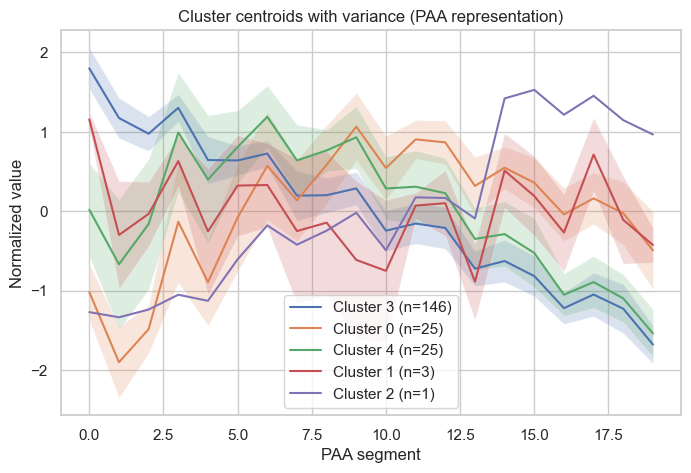

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cluster_counts = pd.Series(final_labels_reps).value_counts().sort_index()
sorted_clusters = cluster_counts.sort_values(ascending=False).index

plt.figure(figsize=(8,5))
for i in sorted_clusters:
    cluster_ts = PAA_reps[final_labels_reps == i]
    centroid = cluster_ts.mean(axis=0)
    std_dev = cluster_ts.std(axis=0)
    plt.plot(centroid, label=f"Cluster {i} (n={cluster_counts[i]})")
    plt.fill_between(np.arange(len(centroid)), centroid - std_dev, centroid + std_dev, alpha=0.2)
plt.title("Cluster centroids with variance (PAA representation)")
plt.xlabel("PAA segment")
plt.ylabel("Normalized value")
plt.legend()
plt.show()


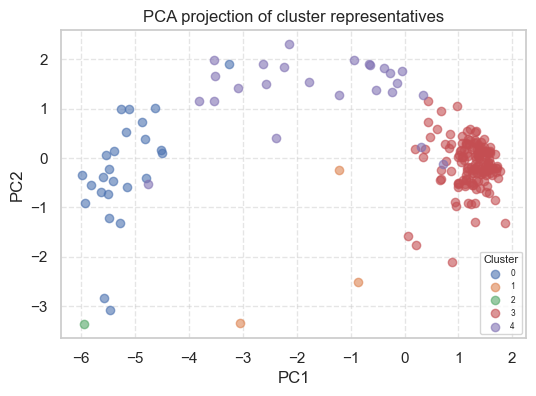

In [75]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(PAA_reps)

plt.figure(figsize=(6,4))
for c in np.unique(final_labels_reps):
    plt.scatter(X_2d[final_labels_reps==c,0], X_2d[final_labels_reps==c,1], label=str(c), alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of cluster representatives")
plt.legend(loc='lower right', fontsize=6, title='Cluster', title_fontsize=8)
plt.grid(alpha=0.5, linestyle='--')
plt.show()


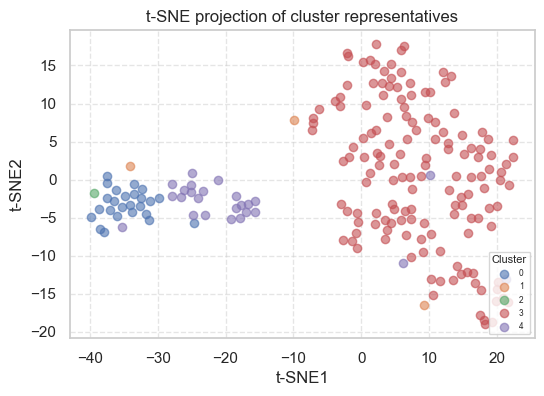

In [77]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=15, max_iter=1000)
X_tsne = tsne.fit_transform(PAA_reps)

plt.figure(figsize=(6,4))
for c in np.unique(final_labels_reps):
    plt.scatter(X_tsne[final_labels_reps==c,0], X_tsne[final_labels_reps==c,1], label=str(c), alpha=0.6)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE projection of cluster representatives")
plt.legend(loc='lower right', fontsize=6, title='Cluster', title_fontsize=8)
plt.grid(alpha=0.5, linestyle='--')
plt.show()
